In [2374]:
import matplotlib.pyplot as plt
import pandas as pd
import os
import numpy as np
import librosa
import librosa.display
from sklearn.preprocessing import StandardScaler , MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense ,Dropout
from keras.layers import Bidirectional
import glob
import keras
from sklearn.preprocessing import LabelEncoder
import tensorflow_io as tfio
from scipy.io import wavfile as wav
from sklearn.neighbors import KNeighborsClassifier
from keras.callbacks import EarlyStopping
from iteration_utilities import flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten,LSTM,GRU,SimpleRNN
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [2009]:
files = glob.glob('train3/*/*')
files1 = glob.glob('train3/*\\')
filenames = []
shaikh1 = []
len(files)
for i in files:
#     filenames.append(str(i).split('\\')[2])
    shaikh1.append(str(i).split('\\')[1])
len(shaikh1)

5420

In [2010]:
df = pd.DataFrame()
df['fileName'] = files
df['shaikh'] = shaikh1

In [2011]:
df[df['shaikh']=='Alsudais']

,fileName,shaikh
912,train3\Alsudais\alsudais_001.wav,Alsudais
913,train3\Alsudais\alsudais_002.wav,Alsudais
914,train3\Alsudais\alsudais_003.wav,Alsudais
915,train3\Alsudais\alsudais_004.wav,Alsudais
916,train3\Alsudais\alsudais_005.wav,Alsudais
...,...,...
1315,train3\Alsudais\alsudais_404.wav,Alsudais
1316,train3\Alsudais\alsudais_405.wav,Alsudais
1317,train3\Alsudais\alsudais_406.wav,Alsudais
1318,train3\Alsudais\alsudais_407.wav,Alsudais


In [2012]:
df['shaikh'].value_counts()

Abdullah albuaijan    456
Ali alhothaify        456
Bander_Balilah        456
Maher Al-Mu_aiqly     456
Mohammed ayoub        456
Nasser Alqutami       456
Saud Al-Shuraim       456
Yasser aldossary      456
عبدالباري             456
محمد اللحيدان         456
Saad_alghamdi         452
Alsudais              408
Name: shaikh, dtype: int64

In [2375]:
def features_extractor(file):
    X, sample_rate = librosa.load(file, res_type='kaiser_fast' ) 
    
    mfccs_features = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    # Generates a Short-time Fourier transform (STFT) to use in the chroma_stft
    stft = np.abs(librosa.stft(X))

    # Computes a chromagram from a waveform or power spectrogram.
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)

    # Computes a mel-scaled spectrogram.
    mel = np.mean(librosa.feature.melspectrogram(y=X, sr=sample_rate).T,axis=0)

    # Computes spectral contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sample_rate).T,axis=0)

    # Computes the tonal centroid features (tonnetz)
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(X),
    sr=sample_rate).T,axis=0)    

    return mfccs_scaled_features, chroma, mel, contrast, tonnetz

In [2376]:
# Extract MFCC only
def mfccfeatures_extractor(file):
    X, sample_rate = librosa.load(file, res_type='kaiser_fast' ) 
    
    mfccs_features = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=128)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features

In [2026]:
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(df.iterrows()):
    file_name = str(row['fileName'])
    final_class_labels=row["shaikh"]
    data=mfccfeatures_extractor(file_name)
    extracted_features.append([data,final_class_labels])

5420it [03:05, 29.28it/s]


In [2027]:
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
#extracted_features_df.to_csv('Audio-features-all40mfcc.csv')
extracted_features_df.info()
#audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5420 entries, 0 to 5419
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   feature  5420 non-null   object
 1   class    5420 non-null   object
dtypes: object(2)
memory usage: 84.8+ KB


In [2028]:
#extracted_features_df = pd.read_csv('Audio-features-all.csv')

## use this only if you used feature_extraction function

In [2029]:
#extracted_features_df['feature'] = extracted_features_df['feature'].apply(lambda x : list(flatten(x)))

In [2395]:
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [2396]:
classes = pd.get_dummies(y).columns

In [2397]:
y=np.array(pd.get_dummies(y)).astype(float)


In [2398]:
X.shape


(5420, 100)

In [2399]:
X

array([[-3.4920532e+02,  4.0207638e+01, -4.8650562e+01, ...,
         2.1619406e-01, -3.2071085e+00, -2.9457867e+00],
       [-2.3936168e+02,  6.0507015e+01, -6.3814449e+01, ...,
        -6.4836127e-01,  2.9148033e-01, -2.8125005e+00],
       [-1.8958119e+02,  4.5546906e+01, -6.1305943e+01, ...,
         1.8633782e+00,  4.5844486e-01, -2.1677577e+00],
       ...,
       [-3.0289404e+02,  1.4032712e+02, -3.0812325e+01, ...,
         9.8014987e-01, -8.6122823e-01, -8.4760910e-01],
       [-2.9808957e+02,  1.3415697e+02, -3.8785488e+01, ...,
         1.4325088e+00, -1.3785475e+00, -3.9927323e+00],
       [-2.8300867e+02,  1.2681820e+02, -2.9787472e+01, ...,
        -3.4880319e-01, -4.1795895e-01, -3.4757662e+00]], dtype=float32)

In [2383]:
# X_train, X_test, y_train, y_test = train_test_split(X,y, train_size=0.8) 
# test_size = 0.5
# X_val, X_test, y_val, y_test = train_test_split(X_test,y_test, test_size=0.5)

In [2384]:
sc = StandardScaler()
X_train = sc.fit_transform(X)
# X_test = sc.transform(X_test)
# X_val = sc.transform(X_val)

In [2385]:
X2 = np.expand_dims(X_train,1)
X2[0].shape

(1, 100)

In [2386]:
X_train

array([[-1.3675033 , -2.0289152 , -0.22541858, ...,  0.4528009 ,
        -1.9144421 , -1.7015303 ],
       [ 0.00504456, -1.5057979 , -0.7184248 , ..., -0.21730922,
         0.60720414, -1.6023736 ],
       [ 0.6270751 , -1.8913217 , -0.6368686 , ...,  1.7295204 ,
         0.7275456 , -1.1227249 ],
       ...,
       [-0.78882205,  0.5511752 ,  0.35453576, ...,  1.044937  ,
        -0.22362316, -0.14061594],
       [-0.7287879 ,  0.39216968,  0.09531336, ...,  1.3955569 ,
        -0.5964867 , -2.4803932 ],
       [-0.54034495,  0.20304881,  0.38785562, ...,  0.01487591,
         0.09586802, -2.0958023 ]], dtype=float32)

In [2387]:
X2

array([[[-1.3675033 , -2.0289152 , -0.22541858, ...,  0.4528009 ,
         -1.9144421 , -1.7015303 ]],

       [[ 0.00504456, -1.5057979 , -0.7184248 , ..., -0.21730922,
          0.60720414, -1.6023736 ]],

       [[ 0.6270751 , -1.8913217 , -0.6368686 , ...,  1.7295204 ,
          0.7275456 , -1.1227249 ]],

       ...,

       [[-0.78882205,  0.5511752 ,  0.35453576, ...,  1.044937  ,
         -0.22362316, -0.14061594]],

       [[-0.7287879 ,  0.39216968,  0.09531336, ...,  1.3955569 ,
         -0.5964867 , -2.4803932 ]],

       [[-0.54034495,  0.20304881,  0.38785562, ...,  0.01487591,
          0.09586802, -2.0958023 ]]], dtype=float32)

In [2401]:
num_labels=y.shape[1]

In [2400]:
y.shape

(5420, 12)

# ANN

In [2098]:
model=Sequential()
###first layer
model.add(Dense(128,input_shape=(128,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# model.add(Dense(80))
# model.add(Activation('relu'))
# model.add(Dropout(0.3))

model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(32))
model.add(Activation('relu'))
model.add(Dropout(0.50))

# model.add(Dense(15))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))



###final layer
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [2099]:
model.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_188 (Dense)           (None, 100)               10100     
                                                                 
 activation_188 (Activation)  (None, 100)              0         
                                                                 
 dropout_143 (Dropout)       (None, 100)               0         
                                                                 
 dense_189 (Dense)           (None, 64)                6464      
                                                                 
 activation_189 (Activation)  (None, 64)               0         
                                                                 
 dropout_144 (Dropout)       (None, 64)                0         
                                                                 
 dense_190 (Dense)           (None, 32)              

In [2100]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [2112]:
## Trianing the model
num_epochs = 50
num_batch_size = 32
model.fit(X_train, y, batch_size=num_batch_size,  epochs=num_epochs)

Epoch 1/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0616 - accuracy: 0.9803
Epoch 2/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0668 - accuracy: 0.9751
Epoch 3/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0663 - accuracy: 0.9779
Epoch 4/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0637 - accuracy: 0.9786
Epoch 5/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0737 - accuracy: 0.9732
Epoch 6/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0649 - accuracy: 0.9769
Epoch 7/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0701 - accuracy: 0.9744
Epoch 8/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0604 - accuracy: 0.9786
Epoch 9/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0778 - accuracy: 0.9721
Epoch 10/50
170/170 [==============================] - 0s 1ms/step - loss: 0.0680 - accuracy: 0.9792

In [2053]:
X = glob.glob('test/*/*')
shaikh = []
for i in X:
    shaikh.append(str(i).split('\\')[1])

In [2054]:
testdf = pd.DataFrame()
testdf['fileName'] = X
testdf['shaikh'] = shaikh
testdf['fileName'] = testdf['fileName'].apply(mfccfeatures_extractor)

In [2188]:
#testdf['fileName'] = testdf['fileName'].apply(lambda x : list(flatten(x)))

In [2224]:
X_test=np.array(testdf['fileName'].tolist())
y_test=np.array(testdf['shaikh'].tolist())

In [2225]:
X_test.max()

235.34198

In [2226]:
X_test = sc.transform(X_test)

In [2227]:
X_test.max()

4.5900583

In [2228]:
X_test

array([[-0.6628302 , -0.12540373,  0.40341124, ...,  0.5032851 ,
         0.6174282 , -0.2360052 ],
       [-0.08450731, -0.20879288,  0.21163297, ...,  0.6652044 ,
         0.51495105, -0.46363103],
       [ 0.2895754 ,  0.69824445,  0.05096314, ...,  0.21831211,
         0.42927796, -0.23347327],
       ...,
       [-0.61025524,  0.74902457,  0.20177512, ...,  0.5179569 ,
        -0.98931617, -0.9197984 ],
       [-0.74034494,  0.75507385,  0.49846062, ...,  0.05872178,
         0.8548559 , -0.81458294],
       [-0.5046516 ,  0.18295188,  0.31398943, ..., -0.24038377,
         0.22873546,  0.01647408]], dtype=float32)

In [2229]:
pred3=model.predict(X_test2)
preds3 = np.argmax(pred3 , axis=-1)

8/8 [==============================] - 0s 3ms/step


In [2230]:
testdf['preds'] = preds3
testdf['preds'] = testdf['preds'].apply(lambda x : classes[x])

In [2231]:
testdf

,fileName,shaikh,preds
0,"[-292.81104, 114.072716, -29.309011, 31.200924...",Abdullah albuaijan,Abdullah albuaijan
1,"[-246.52843, 110.83683, -35.20773, 35.490288, ...",Abdullah albuaijan,Abdullah albuaijan
2,"[-216.59096, 146.03409, -40.149612, 13.561731,...",Abdullah albuaijan,Abdullah albuaijan
3,"[-212.63303, 135.59962, -47.755478, 16.524214,...",Abdullah albuaijan,Abdullah albuaijan
4,"[-209.47556, 67.66363, -76.86442, 30.806728, -...",Abdullah albuaijan,Abdullah albuaijan
...,...,...,...
221,"[-284.23215, 145.02963, -34.791294, 19.861824,...",محمد اللحيدان,محمد اللحيدان
222,"[-276.57303, 144.87843, -39.138412, 10.260729,...",محمد اللحيدان,محمد اللحيدان
223,"[-288.60352, 148.0046, -35.510937, 12.733584, ...",محمد اللحيدان,محمد اللحيدان
224,"[-299.01447, 148.23933, -26.385483, 19.998613,...",محمد اللحيدان,محمد اللحيدان


In [2232]:
len(testdf[testdf['preds'] == testdf['shaikh']])

217

In [2233]:
len(testdf)

226

In [2199]:
testdf[testdf['shaikh'] != testdf['preds']]

,fileName,shaikh,preds
29,"[-198.69734, 235.34198, -67.35536, -17.279825,...",Ali alhothaify,Bander_Balilah
51,"[-165.4175, 19.600697, -57.65998, 34.511295, 1...",Alsudais,عبدالباري
53,"[-193.24167, 58.617744, -65.225204, 53.321964,...",Bander_Balilah,Saud Al-Shuraim
121,"[-201.06348, 31.100157, -75.71766, 47.123886, ...",Saad_alghamdi,Mohammed ayoub
122,"[-170.20424, 37.280167, -77.43387, 54.345566, ...",Saad_alghamdi,Mohammed ayoub
123,"[-170.69899, 50.417625, -94.688, 53.164062, -4...",Saad_alghamdi,Mohammed ayoub
178,"[-208.64801, 199.36922, -20.58997, 3.861803, -...",Yasser aldossary,Nasser Alqutami
179,"[-165.4069, 202.18613, -35.38818, 17.00244, -3...",Yasser aldossary,Nasser Alqutami
182,"[-199.68988, 167.28577, -40.05166, 42.914043, ...",Yasser aldossary,Saud Al-Shuraim


In [2200]:
testdf

,fileName,shaikh,preds
0,"[-292.81104, 114.072716, -29.309011, 31.200924...",Abdullah albuaijan,Abdullah albuaijan
1,"[-246.52843, 110.83683, -35.20773, 35.490288, ...",Abdullah albuaijan,Abdullah albuaijan
2,"[-216.59096, 146.03409, -40.149612, 13.561731,...",Abdullah albuaijan,Abdullah albuaijan
3,"[-212.63303, 135.59962, -47.755478, 16.524214,...",Abdullah albuaijan,Abdullah albuaijan
4,"[-209.47556, 67.66363, -76.86442, 30.806728, -...",Abdullah albuaijan,Abdullah albuaijan
...,...,...,...
221,"[-284.23215, 145.02963, -34.791294, 19.861824,...",محمد اللحيدان,محمد اللحيدان
222,"[-276.57303, 144.87843, -39.138412, 10.260729,...",محمد اللحيدان,محمد اللحيدان
223,"[-288.60352, 148.0046, -35.510937, 12.733584, ...",محمد اللحيدان,محمد اللحيدان
224,"[-299.01447, 148.23933, -26.385483, 19.998613,...",محمد اللحيدان,محمد اللحيدان


In [2201]:
from sklearn.metrics import classification_report , confusion_matrix

In [2202]:
print(classification_report(testdf['shaikh'] , testdf['preds']))

                    precision    recall  f1-score   support

Abdullah albuaijan       1.00      1.00      1.00        16
    Ali alhothaify       1.00      0.97      0.99        34
          Alsudais       1.00      0.67      0.80         3
    Bander_Balilah       0.93      0.93      0.93        15
 Maher Al-Mu_aiqly       1.00      1.00      1.00        15
    Mohammed ayoub       0.84      1.00      0.91        16
   Nasser Alqutami       0.92      1.00      0.96        22
     Saad_alghamdi       1.00      0.80      0.89        15
   Saud Al-Shuraim       0.88      1.00      0.94        15
  Yasser aldossary       1.00      0.91      0.95        33
         عبدالباري       0.96      1.00      0.98        22
     محمد اللحيدان       1.00      1.00      1.00        20

          accuracy                           0.96       226
         macro avg       0.96      0.94      0.95       226
      weighted avg       0.96      0.96      0.96       226



In [2203]:
confusion_matrix = metrics.confusion_matrix(testdf['shaikh'], testdf['preds'])

In [2204]:
tmp = list(classes)

In [2205]:
tmp[-1] = 'Mohammed al Lohaidan'
tmp[-2] = 'Abdulbari'

In [2206]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = tmp)

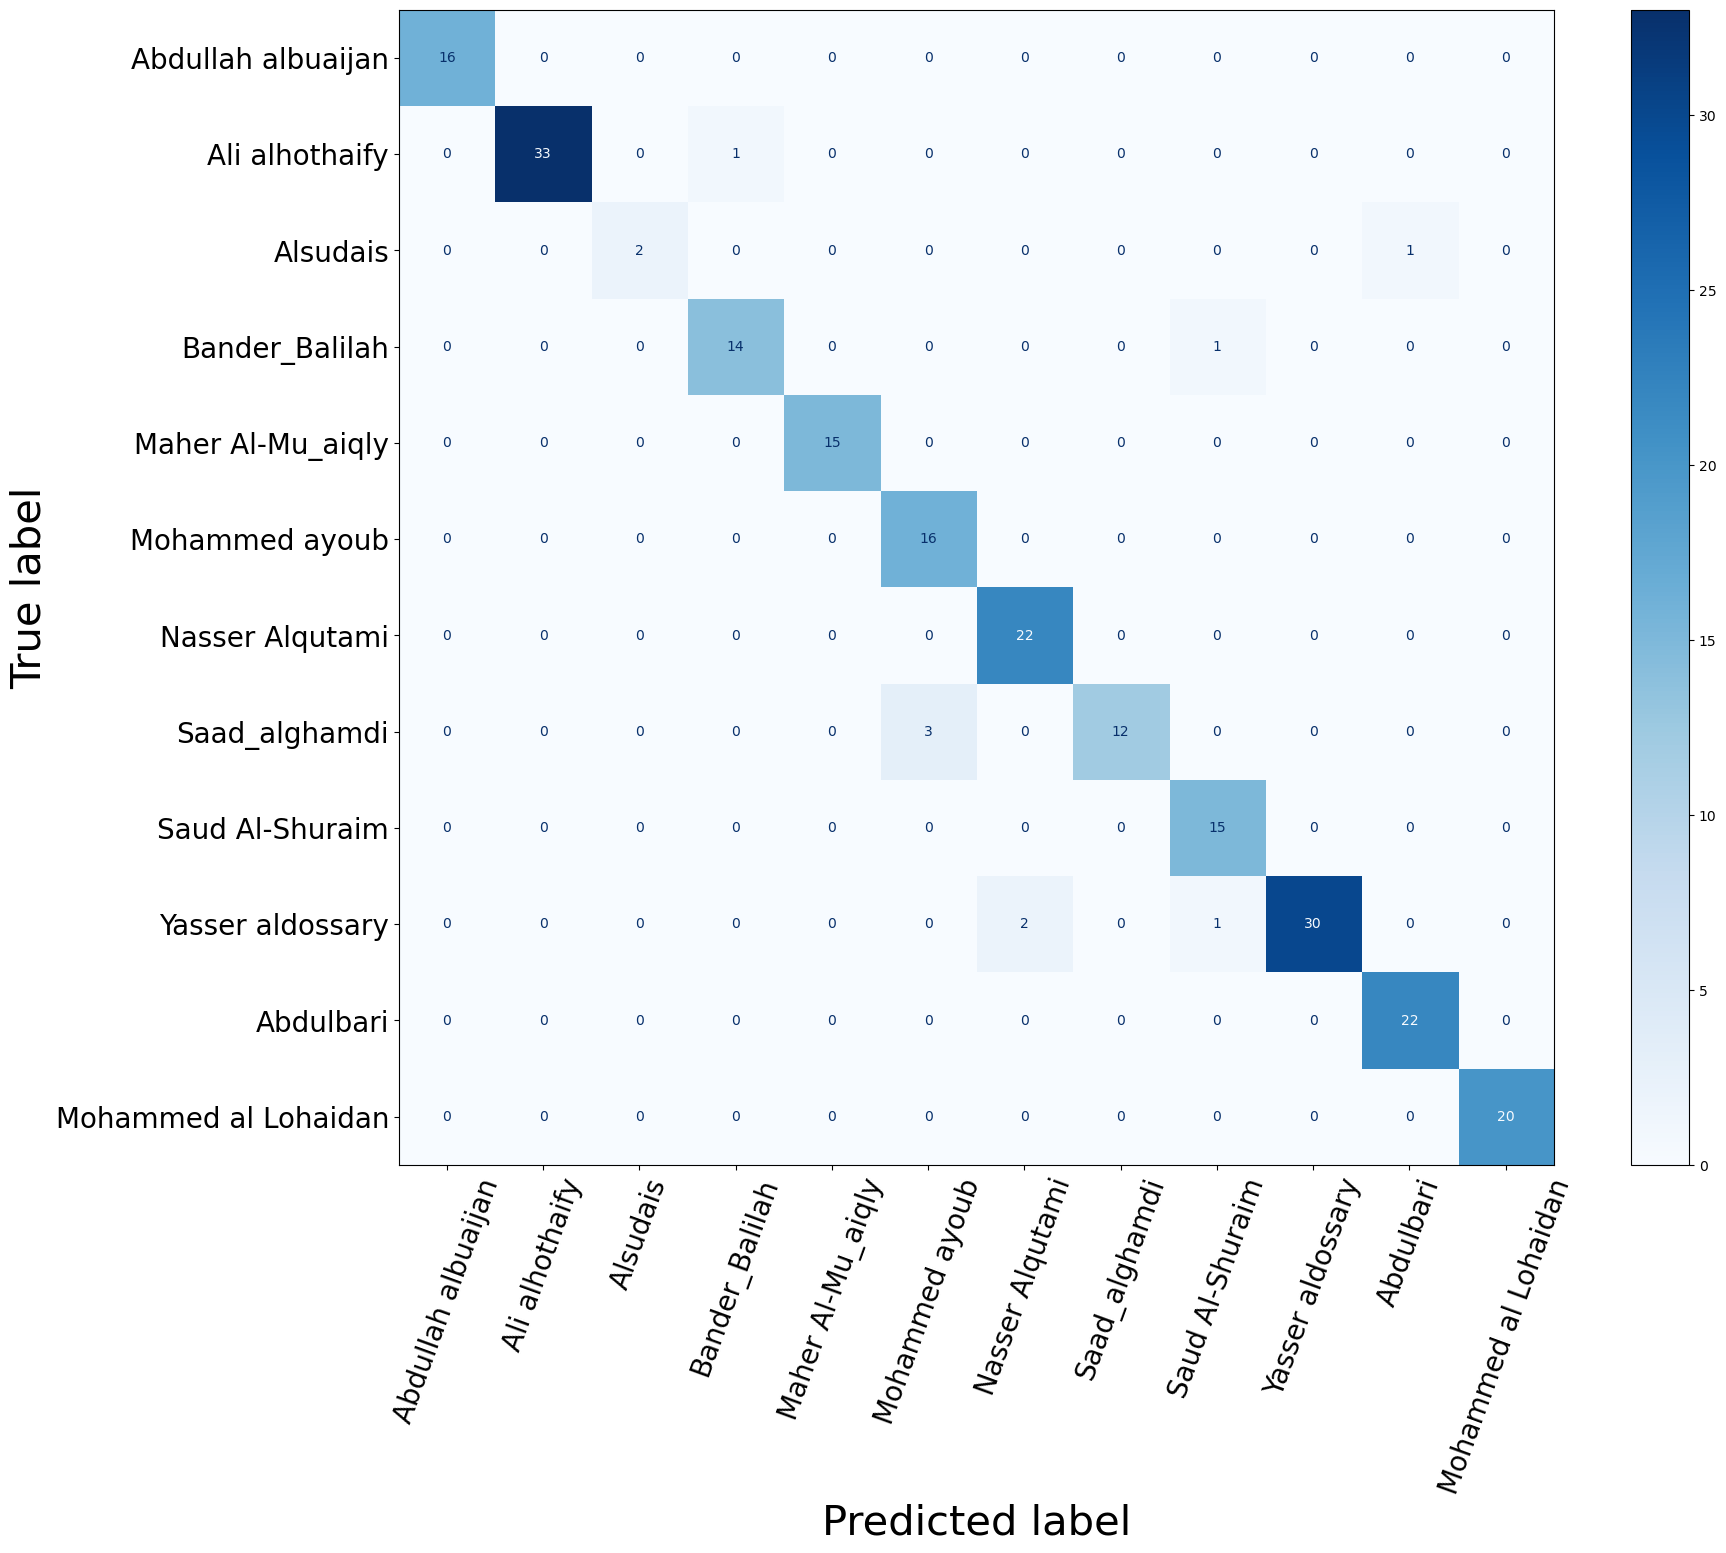

In [2207]:
fig, ax = plt.subplots(figsize=(20, 15))
cm_display.plot(cmap=plt.cm.Blues , xticks_rotation=70 , ax=ax )
ax.tick_params(labelsize=20)
ax.xaxis.get_label().set(fontsize =30)
ax.yaxis.get_label().set(fontsize =30)

plt.show()

# RNN

In [2357]:
model2=Sequential()
###first layer
model2.add(LSTM(100,input_shape=(1,100) , return_sequences=True))
model2.add(Activation('tanh'))
model2.add(Dropout(0.3))

# model2.add(LSTM(80 , return_sequences=True))
# model2.add(Activation('relu'))
# model2.add(Dropout(0.25))

model2.add(LSTM(128, recurrent_dropout=0.2 , return_sequences=True))
model2.add(Activation('tanh'))
model2.add(Dropout(0.7))

model2.add(LSTM(128, recurrent_dropout=0.2))
model2.add(Activation('tanh'))
model2.add(Dropout(0.7))



###final layer
model2.add(Dense(num_labels))
model2.add(Activation('softmax'))

In [2358]:
model2.summary()

Model: "sequential_57"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_32 (LSTM)              (None, 1, 100)            80400     
                                                                 
 activation_236 (Activation)  (None, 1, 100)           0         
                                                                 
 dropout_179 (Dropout)       (None, 1, 100)            0         
                                                                 
 lstm_33 (LSTM)              (None, 1, 128)            117248    
                                                                 
 activation_237 (Activation)  (None, 1, 128)           0         
                                                                 
 dropout_180 (Dropout)       (None, 1, 128)            0         
                                                                 
 lstm_34 (LSTM)              (None, 128)             

In [2359]:
model2.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [2360]:
## Trianing my model

num_epochs = 15
num_batch_size = 32
model2.fit(X2, y, batch_size=num_batch_size, epochs=num_epochs )

Epoch 1/15
170/170 [==============================] - 4s 6ms/step - loss: 2.0421 - accuracy: 0.4347
Epoch 2/15
170/170 [==============================] - 1s 6ms/step - loss: 0.6129 - accuracy: 0.8336
Epoch 3/15
170/170 [==============================] - 1s 6ms/step - loss: 0.2276 - accuracy: 0.9456
Epoch 4/15
170/170 [==============================] - 1s 6ms/step - loss: 0.1129 - accuracy: 0.9780
Epoch 5/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0841 - accuracy: 0.9808
Epoch 6/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0583 - accuracy: 0.9887
Epoch 7/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0396 - accuracy: 0.9926
Epoch 8/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0361 - accuracy: 0.9921
Epoch 9/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0353 - accuracy: 0.9934
Epoch 10/15
170/170 [==============================] - 1s 6ms/step - loss: 0.0243 - accuracy: 0.9959

In [ ]:
#testdf['fileName'] = testdf['fileName'].apply(lambda x : list(flatten(x)))

In [2361]:
X_test2=np.array(testdf['fileName'].tolist())
y_test2=np.array(testdf['shaikh'].tolist())

In [2362]:
X_test2.max()

235.34198

In [2363]:
X_test2 = sc.transform(X_test2)

In [2364]:
X_test2.max()

4.5900583

In [2365]:
X_test2 = np.expand_dims(X_test2,1)
X_test2.shape

(226, 1, 100)

In [2366]:
pred3=model2.predict(X_test2)
preds3 = np.argmax(pred3 , axis=-1)

8/8 [==============================] - 1s 2ms/step


In [2367]:
testdf['preds'] = preds3
testdf['preds'] = testdf['preds'].apply(lambda x : classes[x])

In [2368]:
len(testdf[testdf['preds'] == testdf['shaikh']])

217

In [2369]:
testdf[testdf['preds'] != testdf['shaikh']]

,fileName,shaikh,preds
29,"[-198.69734, 235.34198, -67.35536, -17.279825,...",Ali alhothaify,Bander_Balilah
50,"[-159.44525, 31.31697, -57.163826, 20.330223, ...",Alsudais,Nasser Alqutami
51,"[-165.4175, 19.600697, -57.65998, 34.511295, 1...",Alsudais,محمد اللحيدان
53,"[-193.24167, 58.617744, -65.225204, 53.321964,...",Bander_Balilah,Saud Al-Shuraim
121,"[-201.06348, 31.100157, -75.71766, 47.123886, ...",Saad_alghamdi,Mohammed ayoub
122,"[-170.20424, 37.280167, -77.43387, 54.345566, ...",Saad_alghamdi,Mohammed ayoub
123,"[-170.69899, 50.417625, -94.688, 53.164062, -4...",Saad_alghamdi,Mohammed ayoub
178,"[-208.64801, 199.36922, -20.58997, 3.861803, -...",Yasser aldossary,Nasser Alqutami
179,"[-165.4069, 202.18613, -35.38818, 17.00244, -3...",Yasser aldossary,عبدالباري


In [2370]:
print(classification_report(testdf['shaikh'] , testdf['preds']))

                    precision    recall  f1-score   support

Abdullah albuaijan       1.00      1.00      1.00        16
    Ali alhothaify       1.00      0.97      0.99        34
          Alsudais       1.00      0.33      0.50         3
    Bander_Balilah       0.93      0.93      0.93        15
 Maher Al-Mu_aiqly       1.00      1.00      1.00        15
    Mohammed ayoub       0.84      1.00      0.91        16
   Nasser Alqutami       0.92      1.00      0.96        22
     Saad_alghamdi       1.00      0.80      0.89        15
   Saud Al-Shuraim       0.94      1.00      0.97        15
  Yasser aldossary       1.00      0.94      0.97        33
         عبدالباري       0.96      1.00      0.98        22
     محمد اللحيدان       0.95      1.00      0.98        20

          accuracy                           0.96       226
         macro avg       0.96      0.91      0.92       226
      weighted avg       0.96      0.96      0.96       226



In [2371]:
confusion_matrix = metrics.confusion_matrix(testdf['shaikh'], testdf['preds'])

In [2372]:
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = tmp)

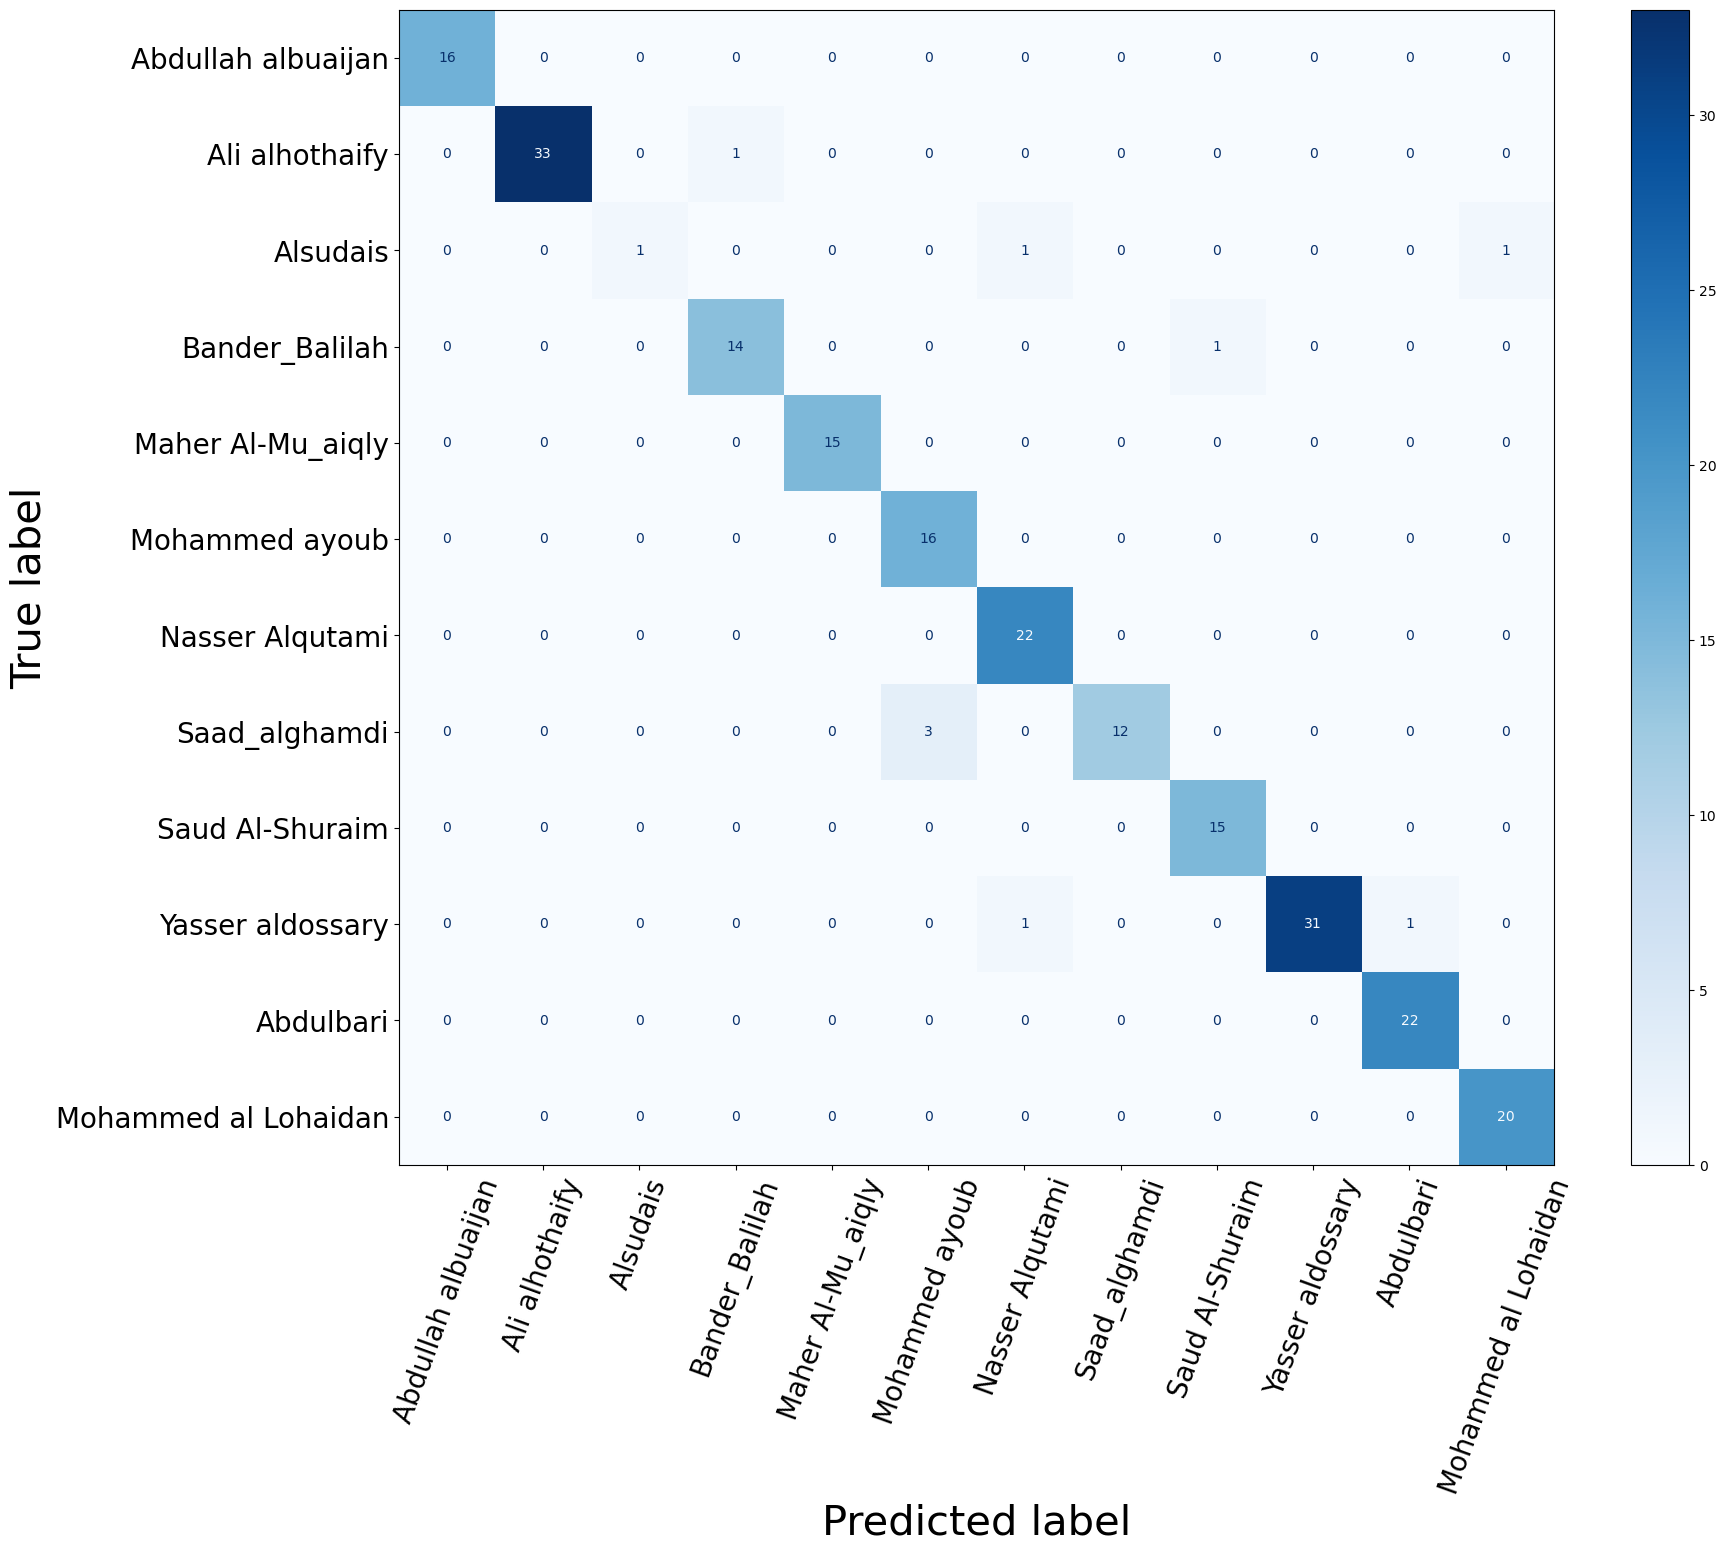

In [2373]:
fig, ax = plt.subplots(figsize=(20, 15))
cm_display.plot(cmap=plt.cm.Blues , xticks_rotation=70 , ax=ax )
ax.tick_params(labelsize=20)
ax.xaxis.get_label().set(fontsize =30)
ax.yaxis.get_label().set(fontsize =30)

plt.show()

## for Saving model and scaler

In [1113]:
#model.save('ANN-2_5-V4.h5')

In [ ]:
#model2.save('RNN-2_5-V4.h5')

In [1114]:
#import pickle

In [1115]:
#pickle.dump(sc , open('scaler2_5-V4.pkl' , 'wb'))